### Load modules

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

from torchvision import transforms, utils,datasets
from torch.utils.data import Dataset, DataLoader
from torch import  optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob

import os
import imageio
import time

### Prepare datasets

#### Load from paths

In [3]:
#get all image and mask paths
image_paths = glob.glob("C:\\Users\\Alexandra\\Desktop\\thesis\\9_week\\data\\imgB\\*.jpg")
mask_paths = glob.glob("C:\\Users\\Alexandra\\Desktop\\thesis\\9_week\\data\\mskB\\*.jpg")

#split paths
len_images = len(image_paths)
print(len_images)
train_size = 0.9

#first part of array is for training and second for testing
train_image_paths = image_paths [:int(len_images*train_size)]
test_image_paths = image_paths[int(len_images*train_size):]

train_mask_paths = mask_paths [:int(len_images*train_size)]
test_mask_paths = mask_paths[int(len_images*train_size):]


90


#### Preprocess the dataset

In [4]:
#dataset class
class image_dataset(Dataset):
    def __init__(self, images, masks, train=True):
        self.images = images
        self.masks = masks

    def transform(self, image,mask):
        resize_im = transforms.Resize(size = (256,256), interpolation=Image.NEAREST)
        resize_m = transforms.Resize(size = (256,256), interpolation=Image.NEAREST)
        gray =  transforms.Grayscale(num_output_channels=1)
        
        image = resize_im(image)
        mask = resize_m(mask)
        
        image = gray(image)
        mask = gray(mask)
        
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        mask = mask.__ge__(0.7).type(torch.FloatTensor) 
        return image,mask
        
    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        mask = Image.open(self.masks[idx])        
        x,y = self.transform(image,mask)
        return x,y
        
    def __len__(self):
        return len(self.images)


#### Create PyTorch dataloaders

In [5]:
train_data = image_dataset(train_image_paths, train_mask_paths, train=True)
train_loader = DataLoader(train_data, batch_size = 3, shuffle = True)

test_data = image_dataset(test_image_paths, test_mask_paths, train = False)
test_loader = DataLoader(test_data, batch_size = 1, shuffle = False)

In [ ]:
print(len(train_loader.dataset))

### Networks

#### Discriminator

In [6]:
class DiscriminatorNet(torch.nn.Module):
    
    #3 hidden-layer discriminative nn
    
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        input_dim = 256+256
        output_dim = 1
        self.label_embedding = nn.Embedding (10,10)
        
        self.hidden0=nn.Sequential(
            nn.Conv2d(1,64,kernel_size=2, stride=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.hidden1=nn.Sequential(
            nn.Conv2d(64,128,kernel_size=2, stride=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.hidden2=nn.Sequential(
            nn.Conv2d(128,256,kernel_size=2, stride=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.out=nn.Sequential(
            nn.Conv2d(256,1,kernel_size=2, stride=2),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x,msk):
        x = torch.cat([x,msk])
        output = self.hidden0(x)
        output = self.hidden1(output)
        output = self.hidden2(output)
        output = self.out(output)
        return output
        


#### Functions to use in the Generator

In [2]:
#double convolution layer
def Conv_double(in_chans, out_chans):
    conv = nn.Sequential(
        nn.Conv2d(in_chans,out_chans, kernel_size =3,padding =1),
        nn.BatchNorm2d(out_chans),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_chans, out_chans, kernel_size =3,padding = 1),
        nn.BatchNorm2d(out_chans),
        nn.ReLU(inplace=True)
    )
    return conv

#crop tensor to concatenate
def Crop_tensor(source, target):
    target_size = target.size()[2]
    source_size = source.size()[2]
    d = source_size - target_size
    if d>1:
        d = (int)(d // 2)
        return source[:,:,d:source_size-d, d:source_size-d]
    else:
        return source[:,:,d:source_size, d:source_size]

In [8]:
# Weight initialization
def weights_init(m): 
    if isinstance(m, nn.Conv2d): 
        nn.init.xavier_normal_(m.weight.data, gain = 1.0) 
       # nn.init.kaiming_uniform_(m.weight.data, a=math.sqrt(5))
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight,1)
        nn.init.constant_(m.bias, 0)

#### Generator

In [9]:
class Generator_UNet(nn.Module):
    def __init__(self):
        super(Generator_UNet, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size =2, stride =2)
        
        #convolutions
        self.down_conv1 = Conv_double(1,64)
        self.down_conv2 = Conv_double(64, 128)
        self.down_conv3 = Conv_double(128, 256)
        self.down_conv4 = Conv_double(256, 512)
        self.down_conv5 = Conv_double(512, 1024)
        
        #up-convolutions
        self.conv_trans1 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size=2, stride=2)
        self.up_conv1 = Conv_double(1024, 512)
        
        self.conv_trans2 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size=2, stride=2)
        self.up_conv2 = Conv_double(512, 256)
        
        self.conv_trans3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size=2, stride=2)
        self.up_conv3 = Conv_double(256, 128)
        
        self.conv_trans4 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size=2, stride=2)
        self.up_conv4 = Conv_double(128, 64)
    
        #output
        self.out = nn.Conv2d(in_channels = 64, out_channels = 1,kernel_size=1)
        
    def forward(self, img):
        #bs,c,h,w
        #encoder
        x1 = self.down_conv1(img) # 
        x2 = self.maxpool(x1)
        x3 = self.down_conv2(x2)   #
        x4 = self.maxpool(x3)
        x5 = self.down_conv3(x4)   #
        x6 = self.maxpool(x5)
        x7 = self.down_conv4(x6)   #
        x8 = self.maxpool(x7)
        x9 = self.down_conv5(x8) 
        
        #decoder
        x = self.conv_trans1(x9)  
        #crop tensor
        y = Crop_tensor(x7, x)        
        #conacatenate
        x = self.up_conv1(torch.cat([x,y],1))
        
        x = self.conv_trans2(x)        
        y = Crop_tensor(x5, x)        
        x = self.up_conv2(torch.cat([x,y],1))
        
        x = self.conv_trans3(x)        
        y = Crop_tensor(x3, x)
        x = self.up_conv3(torch.cat([x,y],1))
        
        x = self.conv_trans4(x)        
        y = Crop_tensor(x1, x)
        x = self.up_conv4(torch.cat([x,y],1))
        
        x = self.out(x)
        
        return x

#### Define device as GPU if available

In [10]:
if torch.cuda.is_available():
    device = 'cuda'

#### GAN model 

In [11]:
class adversarialModel(object):
    def __init__(self, num_epochs=500, samples=3, batch=3, betas=(0.5,0.5),
                g_lr=0.001, d_lr=0.001, size=64, data_path='output/models/',dataloader = train_loader, transforms=None):
           #define parameters
        self.num_epochs=num_epochs
        self.samples = samples
        self.batch = batch
        self.betas = betas
        self.g_lr = g_lr
        self.d_lr = d_lr
        self.size = size
        self.dataset = 'input_data'
        self.name = 'adversarialModel'
        self.output_dir = glob.glob("C:\\Users\\Alexandra\\Desktop\\thesis\\9_week\\res")
        
        self.generator = Generator_UNet()
        self.discriminator = DiscriminatorNet()
        
        #changed betas
        self.optim_g = optim.Adam(self.generator.parameters(), lr = self.g_lr, betas =(0.9, 0.999))
        self.optim_d = optim.Adam(self.discriminator.parameters(), lr = self.d_lr, betas =(0.9, 0.999))
        
        decay_factor = 0.5 
        self.LAMBDA = 100
        
        self.bce_loss = nn.BCELoss()
        self.L1_loss = nn.L1Loss()
        
        self.generator.to(device)
        
        ####weight application 
        self.generator.apply(weights_init)
        
        self.discriminator.to(device)
        
        #dataset,dataloader
        self.dataloader = dataloader
        
        
    def train(self):        
        losses_d = []
        losses_g = []
        acc = []
        for epoch in range(self.num_epochs): 
            total_train = 0
            correct_train = 0
            for batch_idx, (images, masks) in enumerate(self.dataloader):
                
                images =images.to(device)
                masks = masks.to(device)
                #discriminator loss
                self.optim_d.zero_grad()
                
                fake_images = self.generator(masks)
                pred_real = self.discriminator(images, masks)
                ones = torch.ones(pred_real.shape).to(device)
                
                pred_fake = self.discriminator(fake_images, masks)
                zeros = torch.zeros(pred_fake.shape).to(device)
                
                loss_dicriminator_real = self.bce_loss(pred_real,ones)#scheduler
                loss_dicriminator_fake = self.bce_loss(pred_fake,zeros)#*scheduler
                loss_discriminator = loss_dicriminator_real + loss_dicriminator_fake
                
                losses_d.append(loss_discriminator)
                
                loss_discriminator.backward()
                self.optim_d.step()
                
                #generator loss
                self.optim_g.zero_grad()
                
                fake_images = self.generator(masks)
                loss_generator_bce = self.bce_loss(self.discriminator(fake_images,masks),ones)
                loss_generator_l1 = self.L1_loss(fake_images,images) #*scheduler
                loss_generator = loss_generator_bce + loss_generator_l1*self.LAMBDA
                
                losses_g.append(loss_generator)
                
                loss_generator.backward()
                self.optim_g.step()
                
               
                # accuracy
                _, predicted = torch.max(fake_images.data, 1)
                total_train += images.nelement()       
                correct_train += predicted.eq(torch.squeeze(images.data)).sum().item()        
                train_accuracy = 100 * correct_train / total_train
                acc.append(train_accuracy)
                
                
                if(epoch%10 == 0  and batch_idx==0):
                    #self.save(masks,images,fake_images,self.output_dir,epoch )
                    print('Epoch : ', epoch)
                    print("generator loss: ",loss_generator)
                    print("discriminator loss: ",loss_discriminator)
                    print("accuracy: ",train_accuracy)
                if(epoch%50 ==0 and batch_idx==0):
                    plt.title("Model losses")
                    plt.plot(losses_d, label="Discriminator")
                    plt.plot(losses_g, label="Generator")
                    plt.xticks(np.arange(1, epoch+1, 1.0))
                    plt.legend()
                    plt.show()
                    
                if(epoch%50 ==0 and batch_idx==0):
                    ax = plt.axes()
                    plt.title("Model accuracy")
                    plt.plot(acc, label="accuracy")
                    plt.xticks(np.arange(1, epoch, step = 1.0))
                    ax.xaxis.set_major_formatter(plt.NullFormatter())
                    plt.legend()
                    plt.show()
                    
                    
    def evaluate(self, test_loader=test_loader):
        losses_d = []
        losses_g = []
        with torch.no_grad():   
            total_test = 0
            correct_test = 0
            for batch_idx, (images, masks) in enumerate(test_loader):
                
                start = time.time()
                
                images =images.to(device)
                masks = masks.to(device)
               
                fake_images = self.generator(masks)
                pred_real = self.discriminator(images, masks)
                ones = torch.ones(pred_real.shape).to(device)
                
                pred_fake = self.discriminator(fake_images, masks)
                zeros = torch.zeros(pred_fake.shape).to(device)
                
                loss_dicriminator_real = self.bce_loss(pred_real,ones)#scheduler
                loss_dicriminator_fake = self.bce_loss(pred_fake,zeros)#*scheduler
                loss_discriminator = loss_dicriminator_real + loss_dicriminator_fake
            
                fake_images = self.generator(masks)
                loss_generator_bce = self.bce_loss(self.discriminator(fake_images,masks),ones)
                loss_generator_l1 = self.L1_loss(fake_images,images)  #*scheduler
                loss_generator = loss_generator_bce + loss_generator_l1* self.LAMBDA
             
                losses_d.append(loss_discriminator)
                losses_g.append(loss_generator)
                
                # accuracy
                _, predicted = torch.max(fake_images.data, 1)
                total_test += images.nelement()
                correct_test += predicted.eq(torch.squeeze(images.data)).sum().item()    
                test_accuracy = 100 * correct_test / total_test
                
                            
                print("generator loss: ",loss_generator)
                print("discriminator loss: ",loss_discriminator)
                print("test accuracy:", test_accuracy)
                
                end = time.time()
                test_time = end - start
                print('test time for',batch_idx, ' : ', test_time)
    
                fig = plt.figure()
                ax1 = fig.add_subplot(2,2,1)
                ax1.imshow(np.squeeze(masks[0].cpu().detach().numpy()),cmap = 'gray')
                ax2 = fig.add_subplot(2,2,2)
                ax2.imshow(np.squeeze(fake_images[0].cpu().detach().numpy()),cmap = 'gray')    
                ax3 = fig.add_subplot(2,2,3)
                ax3.imshow(np.squeeze(images[0].cpu().detach().numpy()),cmap = 'gray')
        
                plt.show()


### Training and testing

In [12]:
model = adversarialModel(num_epochs=1000, dataloader = train_loader)

Epoch :  0
generator loss:  tensor(54.9181, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3878, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  84.39483642578125


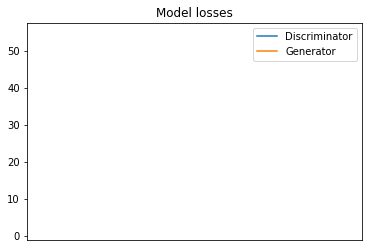

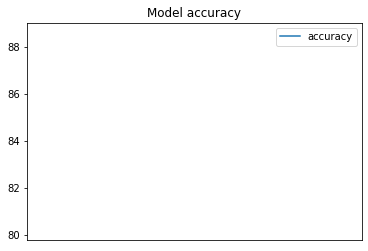

Epoch :  10
generator loss:  tensor(5.7181, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3699, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  90.09145100911458
Epoch :  20
generator loss:  tensor(6.0781, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3570, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  90.850830078125
Epoch :  30
generator loss:  tensor(5.9940, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3804, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  86.33880615234375
Epoch :  40
generator loss:  tensor(6.0039, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3556, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  86.10788981119792
Epoch :  50
generator loss:  tensor(4.9573, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3219, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  88.66221110026042


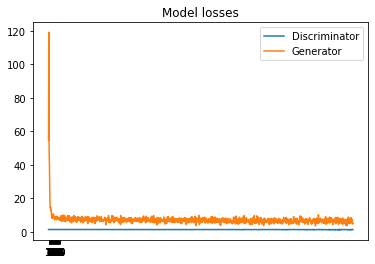

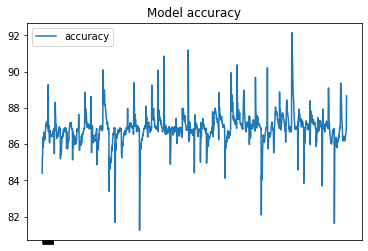

Epoch :  60
generator loss:  tensor(4.9342, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3501, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  85.2020263671875
Epoch :  70
generator loss:  tensor(5.5990, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.1460, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  88.7420654296875
Epoch :  80
generator loss:  tensor(7.2974, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.1832, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  85.88612874348958
Epoch :  90
generator loss:  tensor(6.8167, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.0517, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  82.22300211588542
Epoch :  100
generator loss:  tensor(3.9407, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.0312, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  89.23187255859375


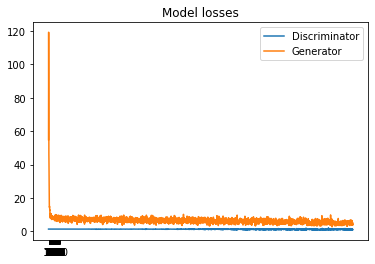

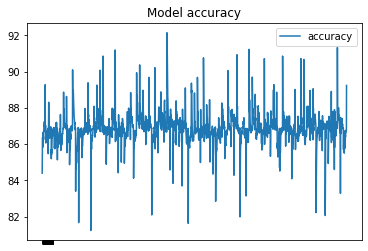

Epoch :  110
generator loss:  tensor(4.0592, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.4867, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  86.08805338541667
Epoch :  120
generator loss:  tensor(3.9454, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.1550, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  87.74515787760417
Epoch :  130
generator loss:  tensor(4.1173, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9426, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  90.8355712890625
Epoch :  140
generator loss:  tensor(4.2654, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.0185, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  88.69425455729167
Epoch :  150
generator loss:  tensor(3.1872, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.1260, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  89.95869954427083


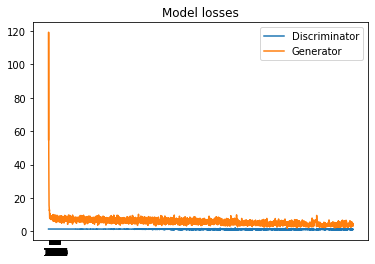

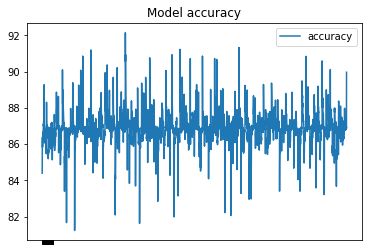

Epoch :  160
generator loss:  tensor(2.7505, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.4431, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  88.2171630859375
Epoch :  170
generator loss:  tensor(3.2906, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9537, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  91.71905517578125
Epoch :  180
generator loss:  tensor(4.3974, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9486, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  89.53653971354167
Epoch :  190
generator loss:  tensor(5.1324, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9044, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  83.96046956380208
Epoch :  200
generator loss:  tensor(2.8701, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.2962, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  85.91715494791667


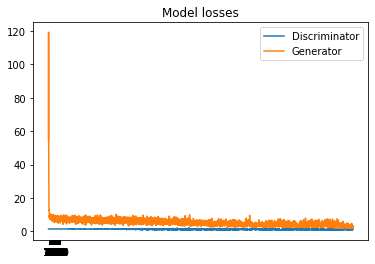

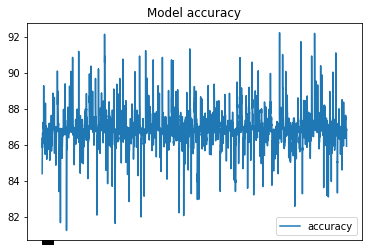

Epoch :  210
generator loss:  tensor(4.8512, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.8856, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  87.79856363932292
Epoch :  220
generator loss:  tensor(4.1131, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9678, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  85.13336181640625
Epoch :  230
generator loss:  tensor(1.5505, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3782, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  88.48317464192708
Epoch :  240
generator loss:  tensor(4.5301, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9109, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  86.35609944661458
Epoch :  250
generator loss:  tensor(2.7347, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9858, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  87.07377115885417


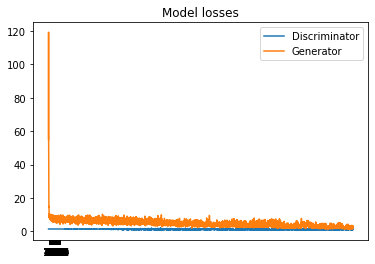

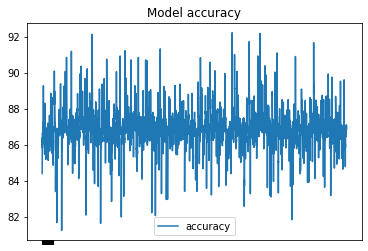

Epoch :  260
generator loss:  tensor(2.8582, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9773, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  87.38555908203125
Epoch :  270
generator loss:  tensor(1.8566, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3218, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  88.41044108072917
Epoch :  280
generator loss:  tensor(2.9918, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9187, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  86.36271158854167
Epoch :  290
generator loss:  tensor(2.3553, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.0620, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  87.63020833333333
Epoch :  300
generator loss:  tensor(3.5561, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9217, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  86.0443115234375


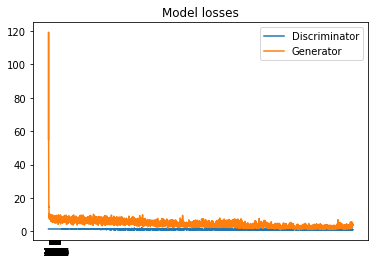

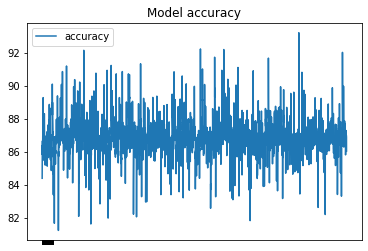

Epoch :  310
generator loss:  tensor(3.3711, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.0243, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  87.07834879557292
Epoch :  320
generator loss:  tensor(2.2046, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9754, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  87.07733154296875
Epoch :  330
generator loss:  tensor(2.1765, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.0244, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  86.15264892578125
Epoch :  340
generator loss:  tensor(2.0177, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.2858, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  87.63224283854167
Epoch :  350
generator loss:  tensor(3.1288, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9192, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  90.753173828125


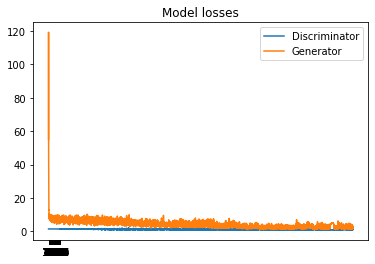

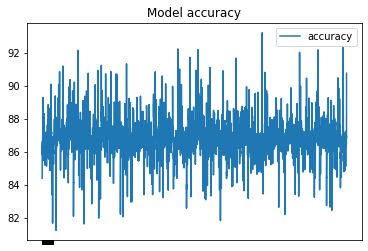

Epoch :  360
generator loss:  tensor(1.5469, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.1887, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  85.48583984375
Epoch :  370
generator loss:  tensor(3.2134, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.0087, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  86.71468098958333
Epoch :  380
generator loss:  tensor(2.0920, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.0568, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  86.29201253255208
Epoch :  390
generator loss:  tensor(2.6511, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9315, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  89.07114664713542
Epoch :  400
generator loss:  tensor(1.5624, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.4133, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  86.28692626953125


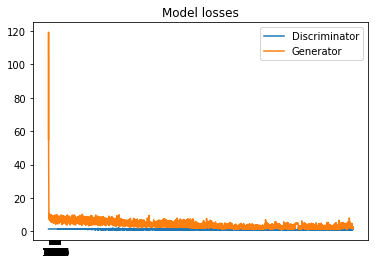

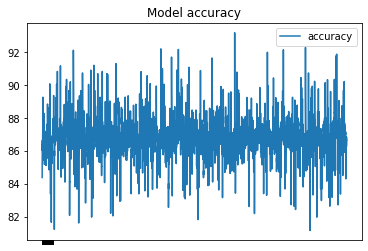

Epoch :  410
generator loss:  tensor(3.1920, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.8630, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  88.83005777994792
Epoch :  420
generator loss:  tensor(2.2476, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.2808, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  86.18418375651042
Epoch :  430
generator loss:  tensor(3.0432, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9842, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  85.321044921875
Epoch :  440
generator loss:  tensor(1.6941, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.0747, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  90.27557373046875
Epoch :  450
generator loss:  tensor(1.1044, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.5231, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  85.662841796875


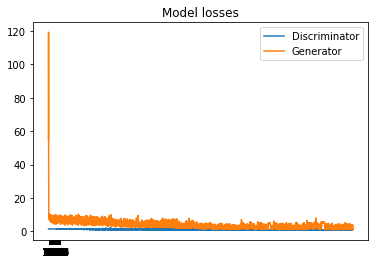

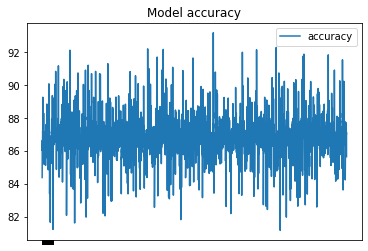

Epoch :  460
generator loss:  tensor(4.5275, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.8811, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  85.91562906901042
Epoch :  470
generator loss:  tensor(2.1751, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9332, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  91.17889404296875
Epoch :  480
generator loss:  tensor(4.9997, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.8747, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  89.21966552734375
Epoch :  490
generator loss:  tensor(2.8378, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9826, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  84.52657063802083
Epoch :  500
generator loss:  tensor(3.9700, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9000, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  85.67250569661458


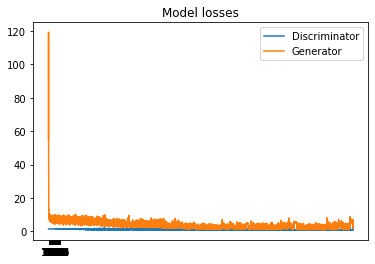

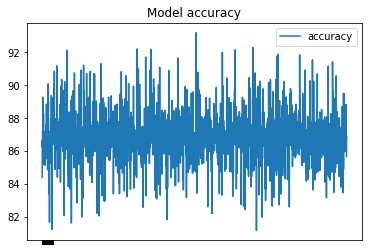

Epoch :  510
generator loss:  tensor(2.3826, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9334, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  87.7349853515625
Epoch :  520
generator loss:  tensor(3.7806, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9105, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  86.76350911458333
Epoch :  530
generator loss:  tensor(1.4485, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.2230, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  85.4400634765625
Epoch :  540
generator loss:  tensor(1.3082, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.4728, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  88.80767822265625
Epoch :  550
generator loss:  tensor(3.0284, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.8990, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  85.41717529296875


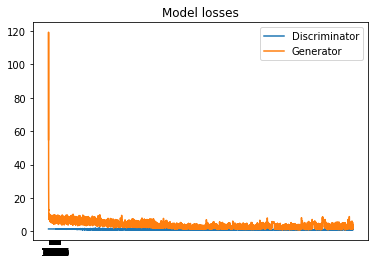

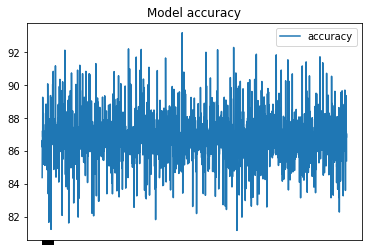

Epoch :  560
generator loss:  tensor(2.2552, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.0345, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  82.81656901041667
Epoch :  570
generator loss:  tensor(1.3756, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3333, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  86.40950520833333
Epoch :  580
generator loss:  tensor(4.6307, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9185, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  87.32808430989583
Epoch :  590
generator loss:  tensor(4.8659, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.8805, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  89.02537027994792
Epoch :  600
generator loss:  tensor(3.0390, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9308, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  83.69649251302083


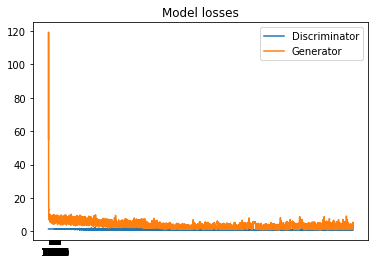

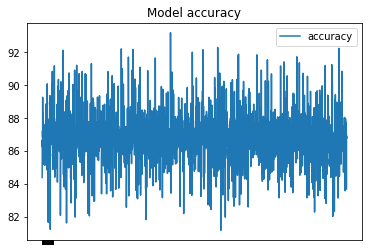

Epoch :  610
generator loss:  tensor(2.3991, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9869, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  86.00260416666667
Epoch :  620
generator loss:  tensor(3.3123, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.8827, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  87.85756429036458
Epoch :  630
generator loss:  tensor(6.0361, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.8319, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  88.77461751302083
Epoch :  640
generator loss:  tensor(3.4195, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3104, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  86.68670654296875
Epoch :  650
generator loss:  tensor(2.0093, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9206, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  86.99696858723958


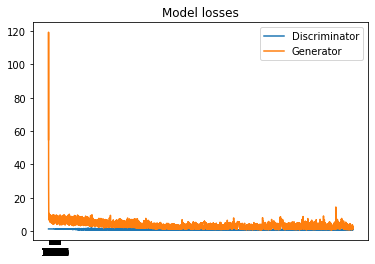

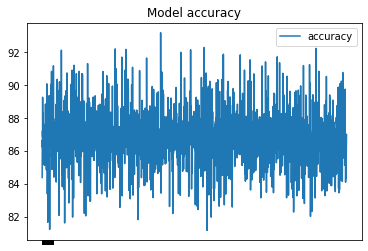

Epoch :  660
generator loss:  tensor(3.9867, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.8643, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  86.94051106770833
Epoch :  670
generator loss:  tensor(1.4244, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.2739, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  82.72349039713542
Epoch :  680
generator loss:  tensor(1.9873, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.1612, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  84.48435465494792
Epoch :  690
generator loss:  tensor(2.4384, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9109, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  88.49538167317708
Epoch :  700
generator loss:  tensor(3.3200, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9105, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  87.32859293619792


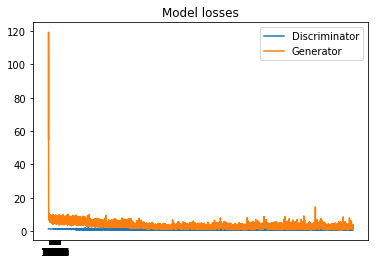

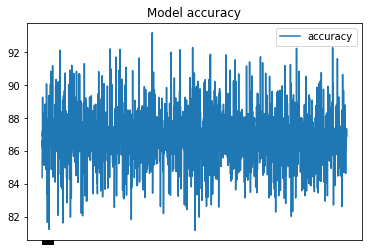

Epoch :  710
generator loss:  tensor(4.1880, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.8688, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  88.39162190755208
Epoch :  720
generator loss:  tensor(4.6334, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.8589, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  89.47194417317708
Epoch :  730
generator loss:  tensor(2.7504, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.0601, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  86.82963053385417
Epoch :  740
generator loss:  tensor(2.0294, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.0238, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  88.57777913411458
Epoch :  750
generator loss:  tensor(1.2984, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3027, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  87.6556396484375


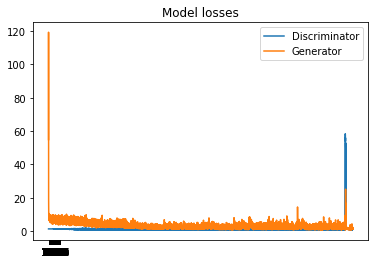

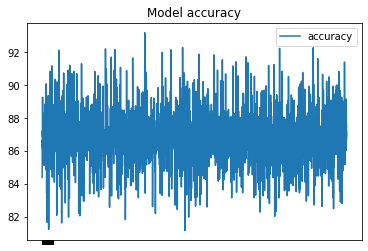

Epoch :  760
generator loss:  tensor(2.3090, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.0115, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  88.90228271484375
Epoch :  770
generator loss:  tensor(1.6969, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.1669, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  82.3486328125
Epoch :  780
generator loss:  tensor(1.9202, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.0376, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  87.29654947916667
Epoch :  790
generator loss:  tensor(1.9615, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9392, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  89.10166422526042
Epoch :  800
generator loss:  tensor(0.8761, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.6770, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  85.98531087239583


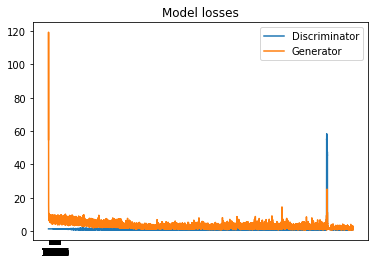

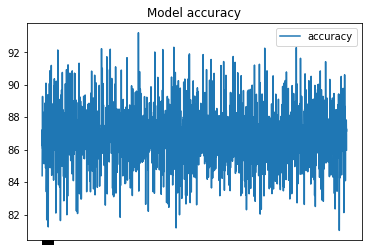

Epoch :  810
generator loss:  tensor(2.6363, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.0165, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  83.978271484375
Epoch :  820
generator loss:  tensor(2.9395, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.8830, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  87.139892578125
Epoch :  830
generator loss:  tensor(2.9999, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.0602, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  86.87032063802083
Epoch :  840
generator loss:  tensor(2.1327, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.0133, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  88.8275146484375
Epoch :  850
generator loss:  tensor(4.9434, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9468, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  85.31646728515625


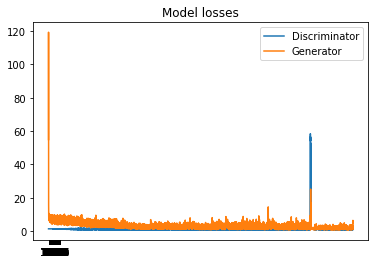

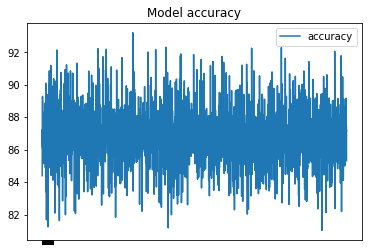

Epoch :  860
generator loss:  tensor(1.7798, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.0884, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  85.27018229166667
Epoch :  870
generator loss:  tensor(3.7894, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.8707, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  89.215087890625
Epoch :  880
generator loss:  tensor(2.6210, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.8849, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  87.06156412760417
Epoch :  890
generator loss:  tensor(3.2564, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9154, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  88.15765380859375
Epoch :  900
generator loss:  tensor(3.5851, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9148, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  82.177734375


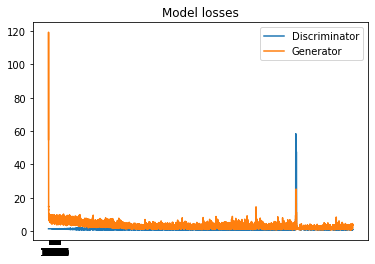

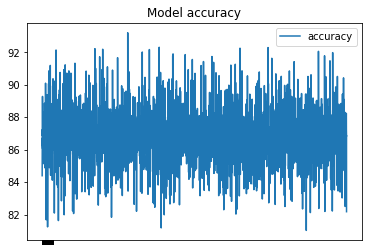

Epoch :  910
generator loss:  tensor(1.8782, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.1293, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  83.56882731119792
Epoch :  920
generator loss:  tensor(1.6890, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.0949, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  85.78745524088542
Epoch :  930
generator loss:  tensor(0.7713, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.8757, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  88.78224690755208
Epoch :  940
generator loss:  tensor(2.3597, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9311, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  87.00612386067708
Epoch :  950
generator loss:  tensor(2.4020, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9184, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  88.92567952473958


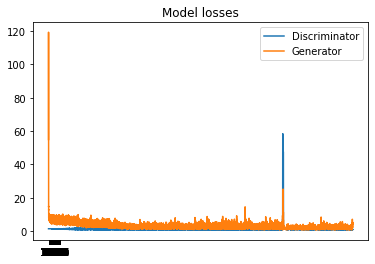

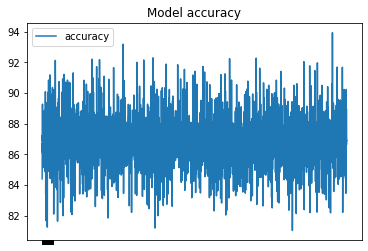

Epoch :  960
generator loss:  tensor(2.8746, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.8841, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  88.24666341145833
Epoch :  970
generator loss:  tensor(3.4076, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.9067, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  83.29315185546875
Epoch :  980
generator loss:  tensor(3.2589, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.8883, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  88.20902506510417
Epoch :  990
generator loss:  tensor(2.8049, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(0.8799, device='cuda:0', grad_fn=<AddBackward0>)
accuracy:  91.5252685546875


In [ ]:
start = time.time()
model.train()
end = time.time()
training_time = end - start
print('training time: ', training_time)

In [15]:
print('training time: ', training_time)

training time:  44598.19407963753


generator loss:  tensor(7.0936, device='cuda:0')
discriminator loss:  tensor(0.9052, device='cuda:0')
test accuracy: 88.5101318359375
test time for 0  :  0.40891122817993164


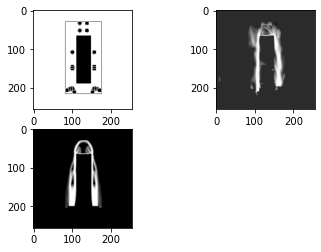

generator loss:  tensor(5.8798, device='cuda:0')
discriminator loss:  tensor(0.8681, device='cuda:0')
test accuracy: 88.33770751953125
test time for 1  :  0.25032496452331543


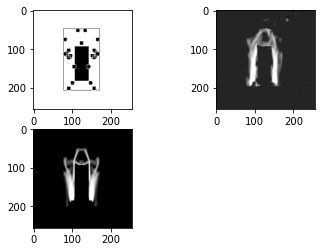

generator loss:  tensor(7.3858, device='cuda:0')
discriminator loss:  tensor(0.9783, device='cuda:0')
test accuracy: 86.72281901041667
test time for 2  :  0.21645474433898926


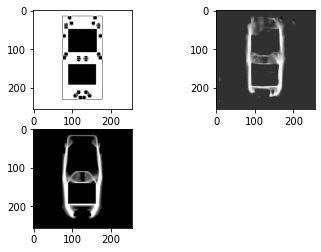

generator loss:  tensor(9.1543, device='cuda:0')
discriminator loss:  tensor(0.9651, device='cuda:0')
test accuracy: 85.46943664550781
test time for 3  :  0.22041082382202148


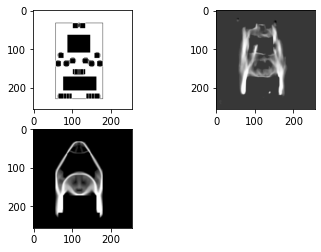

generator loss:  tensor(10.6216, device='cuda:0')
discriminator loss:  tensor(0.9620, device='cuda:0')
test accuracy: 85.53680419921875
test time for 4  :  0.2234039306640625


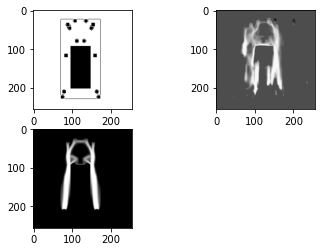

generator loss:  tensor(6.2668, device='cuda:0')
discriminator loss:  tensor(0.8908, device='cuda:0')
test accuracy: 85.92147827148438
test time for 5  :  0.21889829635620117


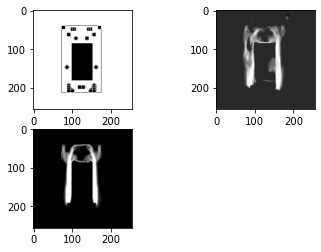

generator loss:  tensor(14.5257, device='cuda:0')
discriminator loss:  tensor(1.0243, device='cuda:0')
test accuracy: 84.98753138950893
test time for 6  :  0.22080421447753906


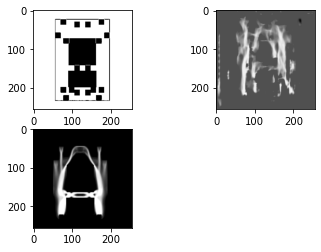

generator loss:  tensor(6.5233, device='cuda:0')
discriminator loss:  tensor(0.9193, device='cuda:0')
test accuracy: 85.19172668457031
test time for 7  :  0.21741819381713867


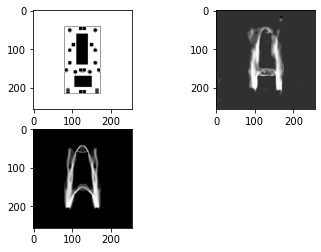

generator loss:  tensor(10.2118, device='cuda:0')
discriminator loss:  tensor(0.9367, device='cuda:0')
test accuracy: 84.72900390625
test time for 8  :  0.21944570541381836


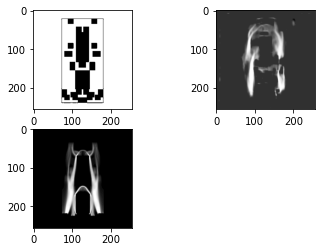

In [14]:
model.evaluate()

In [ ]:
path = './saved_model'
torch.save(model.generator.state_dict(), path)